In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
 
from random import choice,shuffle
from scipy import stats as st
 
from collections import deque

In [2]:
def gather_data(num_samples):
     
    global rock, paper, scissor, nothing
     
    # Initialize the camera
    cap = cv2.VideoCapture(0)
 
    # trigger tells us when to start recording
    trigger = False
     
    # Counter keeps count of the number of samples collected
    counter = 0
     
    # This the ROI size, the size of images saved will be box_size -10
    box_size = 234
     
    # Getting the width of the frame from the camera properties
    width = int(cap.get(3))
 
 
    while True:
         
        # Read frame by frame
        ret, frame = cap.read()
         
        # Flip the frame laterally
        frame = cv2.flip(frame, 1)
         
        # Break the loop if there is trouble reading the frame.
        if not ret:
            break
             
        # If counter is equal to the number samples then reset triger and the counter
        if counter == num_samples:
            trigger = not trigger
            counter = 0
         
        # Define ROI for capturing samples
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
        # Make a resizable window.
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
         
         
        # If trigger is True than start capturing the samples
        if trigger:
             
            # Grab only slected roi
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
             
            # Append the roi and class name to the list with the selected class_name
            eval(class_name).append([roi, class_name])
                                     
            # Increment the counter 
            counter += 1
         
            # Text for the counter
            text = "Collected Samples of {}: {}".format(class_name, counter)
             
        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"
         
        # Show the counter on the imaege
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
         
        # Display the window
        cv2.imshow("Collecting images", frame)
         
        # Wait 1 ms
        k = cv2.waitKey(1)
         
        # If user press 'r' than set the path for rock directoryq
        if k == ord('r'):
             
            # Trigger the variable inorder to capture the samples
            trigger = not trigger
            class_name = 'rock'
            rock = []
            
             
        # If user press 'p' then class_name is set to paper and trigger set to True  
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
         
        # If user press 's' then class_name is set to scissor and trigger set to True  
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
                     
        # If user press 's' then class_name is set to nothing and trigger set to True
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
         
        # Exit if user presses 'q'
        if k == ord('q'):
            break
             
    #  Release the camera and destroy the window
    cap.release()
    cv2.destroyAllWindows()

In [3]:
no_of_samples = 150
gather_data(no_of_samples)

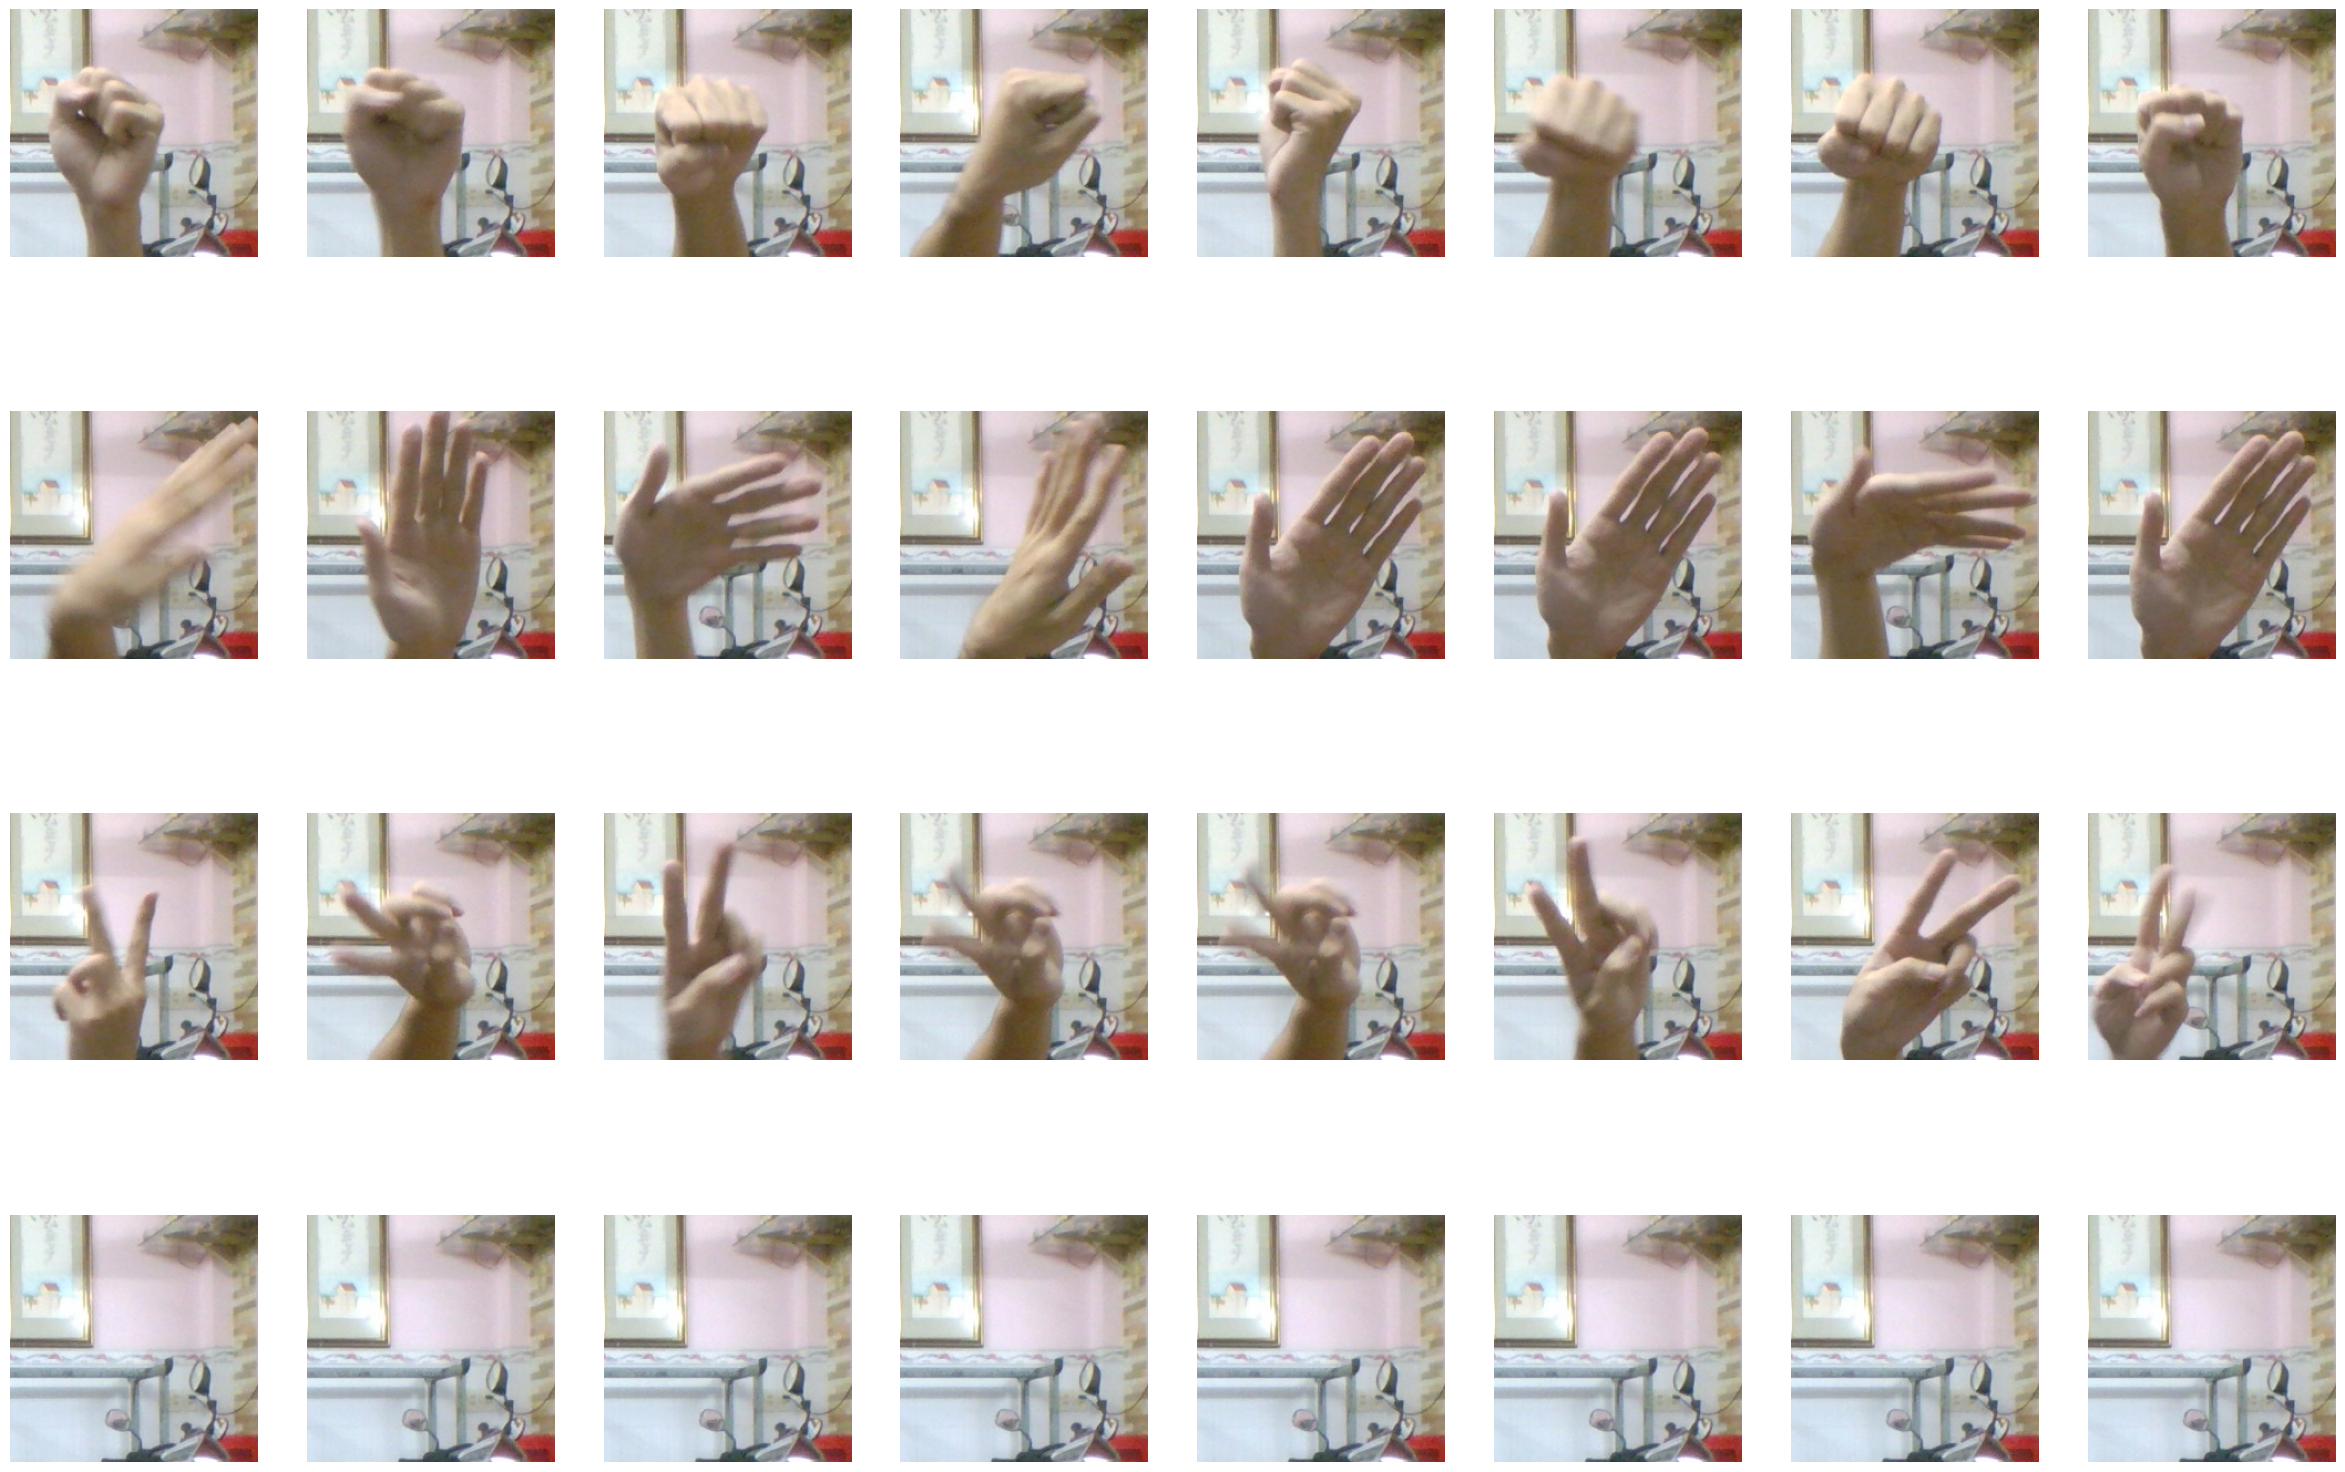

In [4]:
# Set the figure size
plt.figure(figsize=[30,20])
 
# Set the rows and columns
rows, cols = 4, 8
 
# Iterate for each class
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
     
    # Get 8 random indexes, since we will be showing 8 examples of each class.
    r = np.random.randint(no_of_samples, size=8);
     
    # Plot the examples
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');


In [5]:
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]

# Combine the images of all classes together
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]

# Normalize the images
images = np.array(images, dtype="float") / 255.0

# Print out the total number of labels and images.
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))

# Create an encoder Object
encoder = LabelEncoder()

# Convert Labels to integers
Int_labels = encoder.fit_transform(labels)

# Convert the integer labels into one hot format
one_hot_labels = to_categorical(Int_labels, 4)

# Split the data
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.2, random_state=50)

# Empty memory from RAM
images = []

Total images: 600 , Total Labels: 600


In [6]:
from keras import regularizers
image_size = 224

# Augmentation configuration for the training data
augment = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    horizontal_flip=False,
    fill_mode="nearest"
)

# Augmentation configuration for the testing data (only normalization)
test_datagen = ImageDataGenerator()

# Prepare data augmentation
train_generator = augment.flow(trainX, trainY, batch_size=32)
test_generator = test_datagen.flow(testX, testY, batch_size=32)

# Loading pre-trained NASNETMobile Model without the head by doing include_top = False
N_mobile = tf.keras.applications.NASNetMobile(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Freeze the whole model 
N_mobile.trainable = False

# Adding our own custom head
# Start by taking the output feature maps from NASNETMobile
x = N_mobile.output

# Convert to a single-dimensional vector by Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Adding a dense layer with 712 units
x = Dense(712, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.40)(x)
x = Dense(356, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.40)(x)

# The final layer will contain 4 output units (no of units = no of classes) with softmax function
preds = Dense(4, activation='softmax')(x)

# Construct the full model
model = Model(inputs=N_mobile.input, outputs=preds)

# Check the number of layers in the final Model
print("Number of Layers in Model: {}".format(len(model.layers[:])))

Number of Layers in Model: 775


In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
)

# Print logs for each epoch
for epoch, logs in enumerate(zip(history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])):
    print(f'Epoch {epoch+1}/{15}')
    print(f'Loss: {logs[0]}, Accuracy: {logs[1]}, Val_Loss: {logs[2]}, Val_Accuracy: {logs[3]}')

Epoch 1/15


c:\Users\giang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3836 - loss: 13.4944 - val_accuracy: 0.8167 - val_loss: 9.9954
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7716 - loss: 9.3803 - val_accuracy: 0.9250 - val_loss: 7.0352
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8157 - loss: 6.7379 - val_accuracy: 0.9500 - val_loss: 5.1339
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8952 - loss: 4.9222 - val_accuracy: 0.8917 - val_loss: 4.1009
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8769 - loss: 3.8368 - val_accuracy: 0.9250 - val_loss: 3.1633
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8835 - loss: 3.1200 - val_accuracy: 0.9500 - val_loss: 2.5758
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9184 - loss: 2.5824 - val_accuracy: 0.9667 - val_loss: 2.1404
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9027 - loss: 2.1844 - val_accuracy: 0.9667 - val_loss: 1.8507
Ep

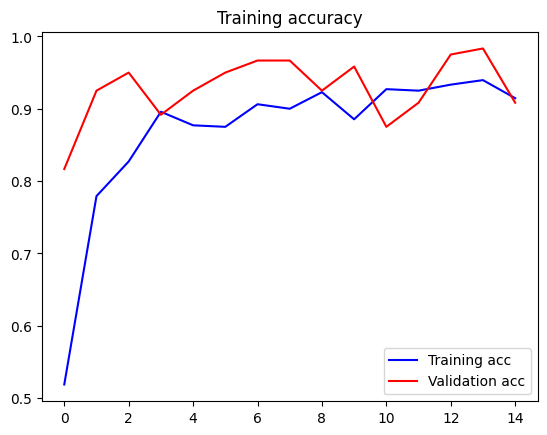

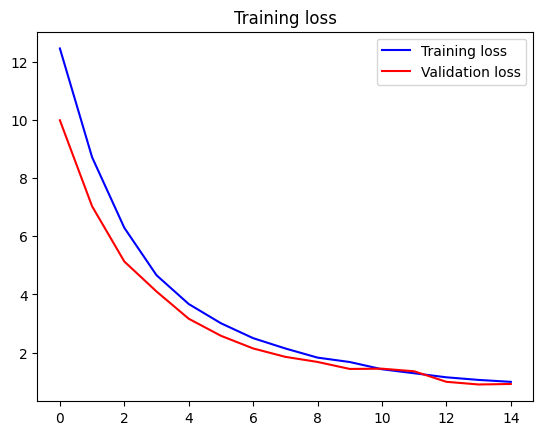

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
 
plt.show()

In [10]:
label_names = ['nothing', 'paper', 'rock', 'scissor']
 
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))
 
while True:
     
    ret, frame = cap.read()
    if not ret:
        break
         
    frame = cv2.flip(frame, 1)
            
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)
 
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
     
    # Normalize the image like we did in the preprocessing step, also convert float64 array.
    roi = np.array([roi]).astype('float64') / 255.0
  
    # Get model's prediction.
    pred = model.predict(roi)
     
    # Get the index of the target class.
    target_index = np.argmax(pred[0])
 
    # Get the probability of the target class
    prob = np.max(pred[0])
 
    # Show results
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
     
    cv2.imshow("Rock Paper Scissors", frame)
     
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
 
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━

In [11]:
import cv2
import numpy as np
import random

label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))

def determine_winner(user_move, computer_move):
    if user_move == computer_move:
        return "Draw"
    elif (user_move == 'rock' and computer_move == 'scissor') or \
         (user_move == 'scissor' and computer_move == 'paper') or \
         (user_move == 'paper' and computer_move == 'rock'):
        return "You win!"
    else:
        return "Computer wins!"

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)

    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    roi = np.array([roi]).astype('float64') / 255.0

    pred = model.predict(roi)
    
    target_index = np.argmax(pred[0])

    prob = np.max(pred[0])

    user_move = label_names[target_index]

    computer_move = random.choice(['paper', 'rock', 'scissor'])

    if user_move != 'nothing':
        result = determine_winner(user_move, computer_move)
    else:
        result = "Waiting for your move..."

    cv2.putText(frame, "Your move: {} {:.2f}%".format(user_move, prob * 100),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Computer move: {}".format(computer_move),
                (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, result,
                (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Rock Paper Scissors", frame)
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━